## Libraries

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Activation, LSTM, Dense, SpatialDropout1D
from tensorflow.keras .preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import re

In [4]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,Video Id,Title,Description,Category
0,0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,3,-LzdIILq5vE,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel


In [5]:
df.shape

(10333, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10333 entries, 0 to 10332
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   10333 non-null  int64 
 1   Video Id     10333 non-null  object
 2   Title        10333 non-null  object
 3   Description  9999 non-null   object
 4   Category     10333 non-null  object
dtypes: int64(1), object(4)
memory usage: 403.8+ KB


In [10]:
df.isnull().sum()

Unnamed: 0       0
Video Id         0
Title            0
Description    334
Category         0
dtype: int64

In [12]:
df = df.dropna()
df.isnull().sum()

Unnamed: 0     0
Video Id       0
Title          0
Description    0
Category       0
dtype: int64

In [13]:
classes = ['travel', 'science and technology', 'food', 'manufacturing', 'history', 'art and music']
str_to_int = {
    'travel': 0,
    'science and technology': 1,
    'food': 2,
    'manufacturing': 3,
    'history': 4,
    'art and music': 5
}

In [18]:
x = df.drop(labels=['Category', 'Video Id'], axis=1)
x

,Unnamed: 0,Title,Description
0,0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg..."
1,1,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...
2,2,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...
3,3,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...
4,4,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M..."
...,...,...,...
10328,10328,Watercolor scenery painting demo - Rainy Day,Watercolor scenery painting demo - Rainy Day O...
10329,10329,Speed painting Blackstone Fortress: Ur-Ghuls,Music by Midwinter Minis. Enjoyed this series?...
10330,10330,Fabric painting step by step flowers painting ...,If you loved the video then please like share ...
10331,10331,The Upside | &quot;Dell Unveils Painting&quot;...,THE UPSIDE is director Neil Burger's heartfelt...


In [19]:
y = df['Category']
y

0               travel
1               travel
2               travel
3               travel
4               travel
             ...      
10328    art and music
10329    art and music
10330    art and music
10331    art and music
10332    art and music
Name: Category, Length: 9999, dtype: object

In [20]:
x = x.reset_index()
y = y.reset_index()
y = y['Category']

In [21]:
for i in range(len(y)):
    if y[i] in str_to_int:
        y[i] = str_to_int[y[i]]

In [22]:
y = to_categorical(y, num_classes=len(classes))

In [24]:
training_text = []
for i in range(len(x)):
    training_text.append(x['Title'][i] + " " + x['Description'][i])

In [25]:
stop_words = stopwords.words('english')

In [26]:
lemmatizer = WordNetLemmatizer()

In [27]:
x_train = []
for sent in training_text:
    sent = re.sub("[^a-zA-Z]", " ", sent)
    sent = sent.lower().split()
    sent = [lemmatizer.lemmatize(word) for word in sent if word not in set(stop_words)]
    sent = ' '.join(sent)
    x_train.append(sent)

In [28]:
padding_length = 70
max_feature_length = 20
vocab_size = 10000

In [29]:
one_hot_encoded = [one_hot(word, vocab_size) for word in x_train]

In [30]:
one_hot_encoded = pad_sequences(one_hot_encoded, truncating='post', padding='post', maxlen=padding_length)

In [33]:
one_hot_encoded = np.array(one_hot_encoded)

In [34]:
x, y = shuffle(one_hot_encoded, y, random_state=2)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

In [37]:
xtrain.shape, ytrain.shape

((7999, 70), (7999, 6))

## Build the model

In [38]:
model = Sequential()
model.add(Embedding(vocab_size, max_feature_length, input_length=padding_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(units=128))
model.add(Dense(units=len(classes)))
model.add(Activation('softmax'))

/home/amina/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-07-16 15:27:39.026485: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(xtrain, ytrain, batch_size=24, epochs=10, validation_data=(xtest, ytest), verbose=1)

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 75s 200ms/step - accuracy: 0.1684 - loss: 0.4739 - val_accuracy: 0.1550 - val_loss: 0.4521
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 74s 176ms/step - accuracy: 0.1658 - loss: 0.4516 - val_accuracy: 0.1650 - val_loss: 0.4515
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 63s 188ms/step - accuracy: 0.1666 - loss: 0.4519 - val_accuracy: 0.1550 - val_loss: 0.4514
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 61s 184ms/step - accuracy: 0.1681 - loss: 0.4515 - val_accuracy: 0.1905 - val_loss: 0.4508
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 54s 163ms/step - accuracy: 0.1724 - loss: 0.4518 - val_accuracy: 0.1615 - val_loss: 0.4521
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 52s 157ms/step - accuracy: 0.1573 - loss: 0.4515 - val_accuracy: 0.1905 - val_loss: 0.4511
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 54s 161ms/step - accuracy: 0.1693 - loss: 0.4514 - val_accuracy: 0.1740 - val_loss: 0.4520
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 53s 160ms/step - accuracy: 0.1604 - loss: 0

In [42]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

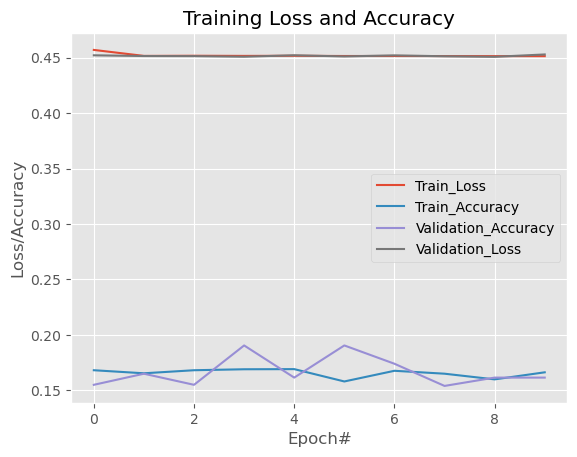

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,10),train_loss,label="Train_Loss")
plt.plot(np.arange(0,10),train_accuracy,label="Train_Accuracy")
plt.plot(np.arange(0,10),val_accuracy,label="Validation_Accuracy")
plt.plot(np.arange(0,10),val_loss,label="Validation_Loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch#")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
plt.close()